# Workshop 1 - **N-body problem**

What to do
- Code an n-body problem simulator, plot the output,
and play around with it
  - Identify ‘good’ or interesting initial conditions
  - Compare with other students
- Check whether the integrals of motion are indeed
constants for your simulation
- Validate results against another source

How to do it
- Use your preferred tools: Python, C++, Matlab,
Mathematica, gnuplot, etc. ...
- Work together with other students:
solve coding problems together
discuss and compare results
- Review extant working examples

Voluntary
- not graded/corrected
- no due date

Tips
For good accuracy at reasonable step size, consider using
a Runge-Kutta-4 (RK4) integrator
- If you do not have much experience with coding or
numerical integration of differential equations,
implementing RK4 can seem challenging.
Try starting with example code in references provided, or
with a numerical integration package in python, C++,
Matlab, or Mathematica, etc.
- Study and implement an algorithm for two bodies, then
expand this to more bodies once this works
- You do not have to use real SI units and realistic solar
system masses and distances. You can set G=1 and use
small numbers for the masses, distances, and velocities

## Import modules

In [ ]:
# Load standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation

## Setup constants and time parameters

In [21]:
# Physical constants
G_gravitational = 6.67430e-11  # m^3 kg^-1 s^-2 (real value)
G_gravitational = 1  # Normalized units for simulation

# Time parameters
time_start = 0      # Start at time zero
time_end = 100        # End time (in normalized units)
time_step = 0.01    # Time step for integration
time_array = np.arange(time_start, time_end, time_step)

## Setup initial conditions and masses

In [22]:
# Number of bodies in the system
num_bodies = 3

# Set random seed for reproducible results
np.random.seed(17)

# Generate random initial conditions
initial_positions = np.random.random((num_bodies, 3))*10  # Initial positions (x, y, z)
initial_velocities = np.random.random((num_bodies, 3))  # Initial velocities (vx, vy, vz)
# initial_velocities = np.zeros_like(initial_positions)  # Null initial velocities (vx, vy, vz)
body_masses = np.ones(num_bodies)  # All masses equal to 1 (normalized units)

# Create state vector: [x1,y1,z1,vx1,vy1,vz1, x2,y2,z2,vx2,vy2,vz2, ...]
# Method 3: Interleaved concatenation (position and velocity for each body)
initial_state = np.array([np.concatenate([initial_positions[i], initial_velocities[i]]) 
                         for i in range(num_bodies)]).flatten()

print(f"State vector shape: {initial_state.shape}")
print(f"System has {num_bodies} bodies with {initial_state.shape[0]} total coordinates")

State vector shape: (18,)
System has 3 bodies with 18 total coordinates


## Equations of motion for N-body problem

In [23]:
def compute_gravitational_acceleration(positions, masses, epsilon=1e-8):
    """
    Compute the gravitational acceleration using vectorized approach.
    
    Parameters:
    - positions: N x 3 array of body positions [x, y, z]
    - masses: N x 1 array of body masses
    - epsilon: small softening parameter to avoid singularities
    
    Returns:
    - acceleration: N x 3 array of gravitational accelerations
    
    Note: This function is kept for reference but not used in the main simulation.
    The diff_equations function below uses a more efficient pairwise approach.
    """
    num_bodies = len(masses)
    
    # Extract coordinates
    x_coords = positions[:, 0]
    y_coords = positions[:, 1]
    z_coords = positions[:, 2]

    # Compute pairwise distance matrices
    dx_matrix = x_coords.T - x_coords
    dy_matrix = y_coords.T - y_coords
    dz_matrix = z_coords.T - z_coords

    # Distance matrix with softening parameter
    distance_matrix = np.sqrt(dx_matrix**2 + dy_matrix**2 + dz_matrix**2) + np.eye(num_bodies)*epsilon

    # Inverse cube distance matrix (avoid division by zero)
    inverse_r_cubed = np.zeros_like(distance_matrix)
    mask = distance_matrix > 0
    inverse_r_cubed[mask] = distance_matrix[mask] ** (-1.5)

    # Compute accelerations
    accel_x = G_gravitational * (dx_matrix * inverse_r_cubed) @ masses
    accel_y = G_gravitational * (dy_matrix * inverse_r_cubed) @ masses
    accel_z = G_gravitational * (dz_matrix * inverse_r_cubed) @ masses

    acceleration = np.column_stack((accel_x, accel_y, accel_z))
    return acceleration

In [24]:
def nbody_differential_equations(state_vector, time, masses, G=G_gravitational, softening=0.0):
    """
    Compute derivatives for the N-body gravitational problem.
    
    Parameters:
    - state_vector: flattened array [x1,y1,z1,vx1,vy1,vz1, ..., xN,yN,zN,vxN,vyN,vzN]
    - time: current time (required by odeint but not used in autonomous system)
    - masses: array of body masses [m1, m2, ..., mN]
    - G: gravitational constant (default uses global value)
    - softening: softening parameter to avoid singularities (optional)
    
    Returns:
    - derivatives: flattened array of time derivatives [vx1,vy1,vz1,ax1,ay1,az1, ...]
    """
    masses = np.asarray(masses, dtype=float)
    num_bodies = len(masses)

    # Reshape state vector into (N, 6) matrix: each row is [x, y, z, vx, vy, vz]
    state_matrix = state_vector.reshape(num_bodies, 6)
    positions = state_matrix[:, 0:3]      # Extract positions (N, 3)
    velocities = state_matrix[:, 3:6]     # Extract velocities (N, 3)

    # Initialize derivatives matrix
    derivatives = np.zeros_like(state_matrix)
    derivatives[:, 0:3] = velocities      # dr/dt = v (position derivatives)

    # Compute accelerations using pairwise interactions (Newton's 3rd law)
    # This approach calculates each pair only once and applies action-reaction
    for i in range(num_bodies - 1):
        for j in range(i + 1, num_bodies):
            # Vector from body i to body j
            position_difference = positions[j] - positions[i]
            
            # Distance squared with softening
            distance_squared = np.dot(position_difference, position_difference) + softening*softening
            
            # Inverse cube distance: 1/|r|^3
            inverse_r_cubed = distance_squared**(-1.5)
            
            # Basic gravitational acceleration (without masses)
            acceleration_unit = G * position_difference * inverse_r_cubed
            
            # Apply to both bodies (Newton's 3rd law: equal and opposite forces)
            derivatives[i, 3:6] += masses[j] * acceleration_unit  # Force on i due to j
            derivatives[j, 3:6] -= masses[i] * acceleration_unit  # Force on j due to i (opposite)

    return derivatives.ravel()  # Flatten back to 1D array

## Numerical solution of the N-body system

In [25]:
# Solve the differential equation system
print("Solving the N-body gravitational system...")
solution = odeint(nbody_differential_equations, initial_state, time_array, 
                 args=(body_masses, G_gravitational, 1e-3))  # Optional softening parameter

print(f"✓ Solution computed successfully!")
print(f"Solution shape: {solution.shape}")
print(f"  - {solution.shape[0]} time steps")
print(f"  - {solution.shape[1]} coordinates ({solution.shape[1]//6} bodies × 6 coords/body)")

Solving the N-body gravitational system...
✓ Solution computed successfully!
Solution shape: (10000, 18)
  - 10000 time steps
  - 18 coordinates (3 bodies × 6 coords/body)


## 3D Visualization of Trajectories

Now we'll plot the trajectories of all bodies in three-dimensional space.

In [26]:
# Extract trajectories for each body from the solution matrix
def extract_body_trajectories(solution_matrix, num_bodies):
    """
    Extract x, y, z positions for each body from the solution matrix.
    
    Parameters:
    - solution_matrix: solution from odeint with shape (time_steps, 6*num_bodies)
    - num_bodies: number of bodies in the system
    
    Returns:
    - trajectories: list of [x_array, y_array, z_array] for each body
    """
    body_trajectories = []
    
    for body_index in range(num_bodies):
        # For each body, extract x, y, z coordinates
        x_coords = solution_matrix[:, 6*body_index]      # x coordinate of body i
        y_coords = solution_matrix[:, 6*body_index + 1]  # y coordinate of body i  
        z_coords = solution_matrix[:, 6*body_index + 2]  # z coordinate of body i
        
        body_trajectories.append([x_coords, y_coords, z_coords])
    
    return body_trajectories

# Extract trajectories for all bodies
trajectories = extract_body_trajectories(solution, num_bodies)

print(f"Trajectories extracted for {num_bodies} bodies")
for i, trajectory in enumerate(trajectories):
    print(f"Body {i+1}: {len(trajectory[0])} trajectory points")
    print(f"  X range: [{np.min(trajectory[0]):.2e}, {np.max(trajectory[0]):.2e}]")
    print(f"  Y range: [{np.min(trajectory[1]):.2e}, {np.max(trajectory[1]):.2e}]")
    print(f"  Z range: [{np.min(trajectory[2]):.2e}, {np.max(trajectory[2]):.2e}]")

Trajectories extracted for 3 bodies
Body 1: 10000 trajectory points
  X range: [2.95e+00, 6.41e+01]
  Y range: [5.31e+00, 8.44e+01]
  Z range: [1.92e+00, 2.83e+01]
Body 2: 10000 trajectory points
  X range: [6.79e-01, 6.99e+01]
  Y range: [7.87e+00, 8.74e+01]
  Z range: [4.45e+00, 2.28e+01]
Body 3: 10000 trajectory points
  X range: [6.38e+00, 6.34e+01]
  Y range: [5.76e+00, 8.45e+01]
  Z range: [3.91e-01, 2.87e+01]


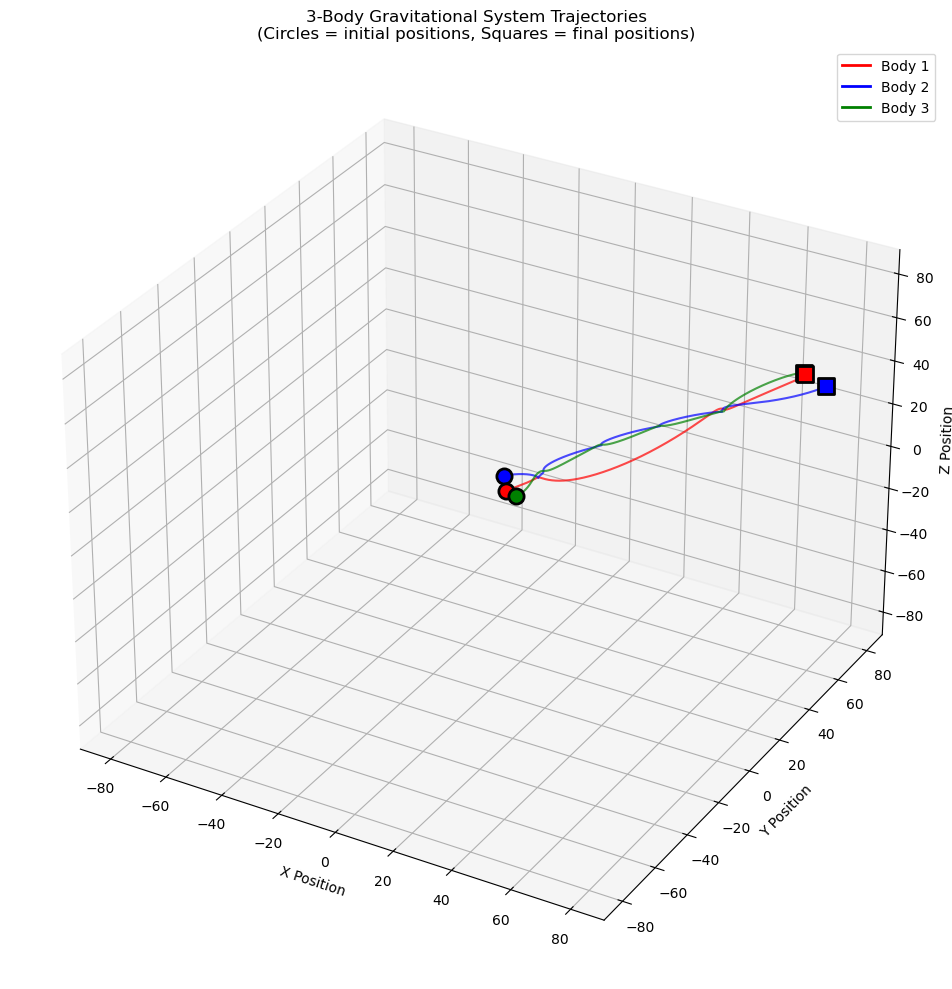

✓ 3D trajectory plot created successfully!


In [27]:
# Create basic 3D plot of all trajectories
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Colors and labels for each body
body_colors = ['red', 'blue', 'green', 'orange', 'purple'][:num_bodies]
body_labels = [f'Body {i+1}' for i in range(num_bodies)]

# Plot each trajectory
for i, (trajectory, color, label) in enumerate(zip(trajectories, body_colors, body_labels)):
    x_coords, y_coords, z_coords = trajectory
    
    # Plot trajectory line
    ax.plot(x_coords, y_coords, z_coords, color=color, alpha=0.7, linewidth=1.5, 
            label=f'{label} (mass={body_masses[i]:.1e})')
    
    # Mark initial position (large circle)
    ax.scatter(x_coords[0], y_coords[0], z_coords[0], color=color, s=120, 
              marker='o', edgecolors='black', linewidth=2, label=f'{label} start')
    
    # Mark final position (square)
    ax.scatter(x_coords[-1], y_coords[-1], z_coords[-1], color=color, s=120, 
              marker='s', edgecolors='black', linewidth=2, label=f'{label} end')

# Configure plot appearance
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title(f'{num_bodies}-Body Gravitational System Trajectories\n'
             f'(Circles = initial positions, Squares = final positions)')

# Create custom legend (avoid too many entries)
legend_elements = []
for i, (color, label) in enumerate(zip(body_colors, body_labels)):
    legend_elements.append(plt.Line2D([0], [0], color=color, lw=2, label=label))
ax.legend(handles=legend_elements)

# Make axes equal scale
all_coords = np.array([trajectories[i][j] for i in range(num_bodies) for j in range(3)]).flatten()
coordinate_range = np.max(np.abs(all_coords))
ax.set_xlim([-coordinate_range, coordinate_range])
ax.set_ylim([-coordinate_range, coordinate_range])
ax.set_zlim([-coordinate_range, coordinate_range])

plt.tight_layout()
plt.show()

print("✓ 3D trajectory plot created successfully!")

Creating 3D animation...


c:\Users\ismag\anaconda3\envs\ismael\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


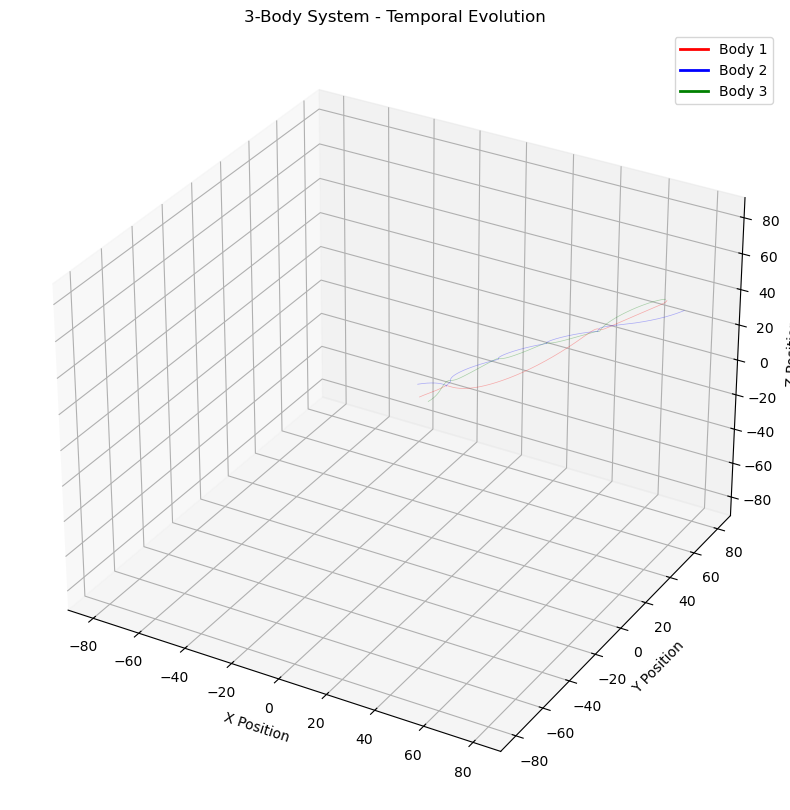

✓ Animation created! Use matplotlib controls to pause/play


In [28]:
# Interactive version: Animated plot showing temporal evolution
def create_animated_3d_plot():
    """Create an animated 3D plot of the N-body system evolution"""
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Set plot limits
    all_coords = np.array([trajectories[i][j] for i in range(num_bodies) for j in range(3)]).flatten()
    coordinate_range = np.max(np.abs(all_coords))
    ax.set_xlim([-coordinate_range, coordinate_range])
    ax.set_ylim([-coordinate_range, coordinate_range])
    ax.set_zlim([-coordinate_range, coordinate_range])
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title(f'{num_bodies}-Body System - Temporal Evolution')
    
    # Initialize plot elements
    trajectory_lines = []
    current_positions = []
    full_trajectories = []
    
    for i in range(num_bodies):
        # Full trajectory (transparent)
        x_coords, y_coords, z_coords = trajectories[i]
        full_traj, = ax.plot(x_coords, y_coords, z_coords, color=body_colors[i], 
                            alpha=0.3, linewidth=0.5)
        full_trajectories.append(full_traj)
        
        # Current trajectory (up to current time)
        current_line, = ax.plot([], [], [], color=body_colors[i], linewidth=2, 
                               label=body_labels[i])
        trajectory_lines.append(current_line)
        
        # Current position marker
        current_point, = ax.plot([], [], [], 'o', color=body_colors[i], markersize=8)
        current_positions.append(current_point)
    
    ax.legend()
    
    # Animation function
    def animate_frame(frame_number):
        # Show every N frames for smoother animation
        time_step = max(1, len(time_array) // 200)  # Show ~200 frames total
        time_index = min(frame_number * time_step, len(time_array) - 1)
        
        for body_i in range(num_bodies):
            x_coords, y_coords, z_coords = trajectories[body_i]
            
            # Update trajectory up to current time
            trajectory_lines[body_i].set_data_3d(x_coords[:time_index+1], 
                                                 y_coords[:time_index+1], 
                                                 z_coords[:time_index+1])
            
            # Update current position
            if time_index < len(x_coords):
                current_positions[body_i].set_data_3d([x_coords[time_index]], 
                                                     [y_coords[time_index]], 
                                                     [z_coords[time_index]])
        
        # Update title with current time
        current_time = time_array[time_index]
        ax.set_title(f'{num_bodies}-Body System - Time: {current_time:.2f}')
        
        return trajectory_lines + current_positions
    
    # Create animation
    total_frames = min(200, len(time_array) // max(1, len(time_array) // 200))
    animation = FuncAnimation(fig, animate_frame, frames=total_frames, 
                             interval=50, blit=False, repeat=True)
    
    return fig, animation

# Create and display animation
print("Creating 3D animation...")
animated_figure, animation_object = create_animated_3d_plot()
plt.show()

print("✓ Animation created! Use matplotlib controls to pause/play")

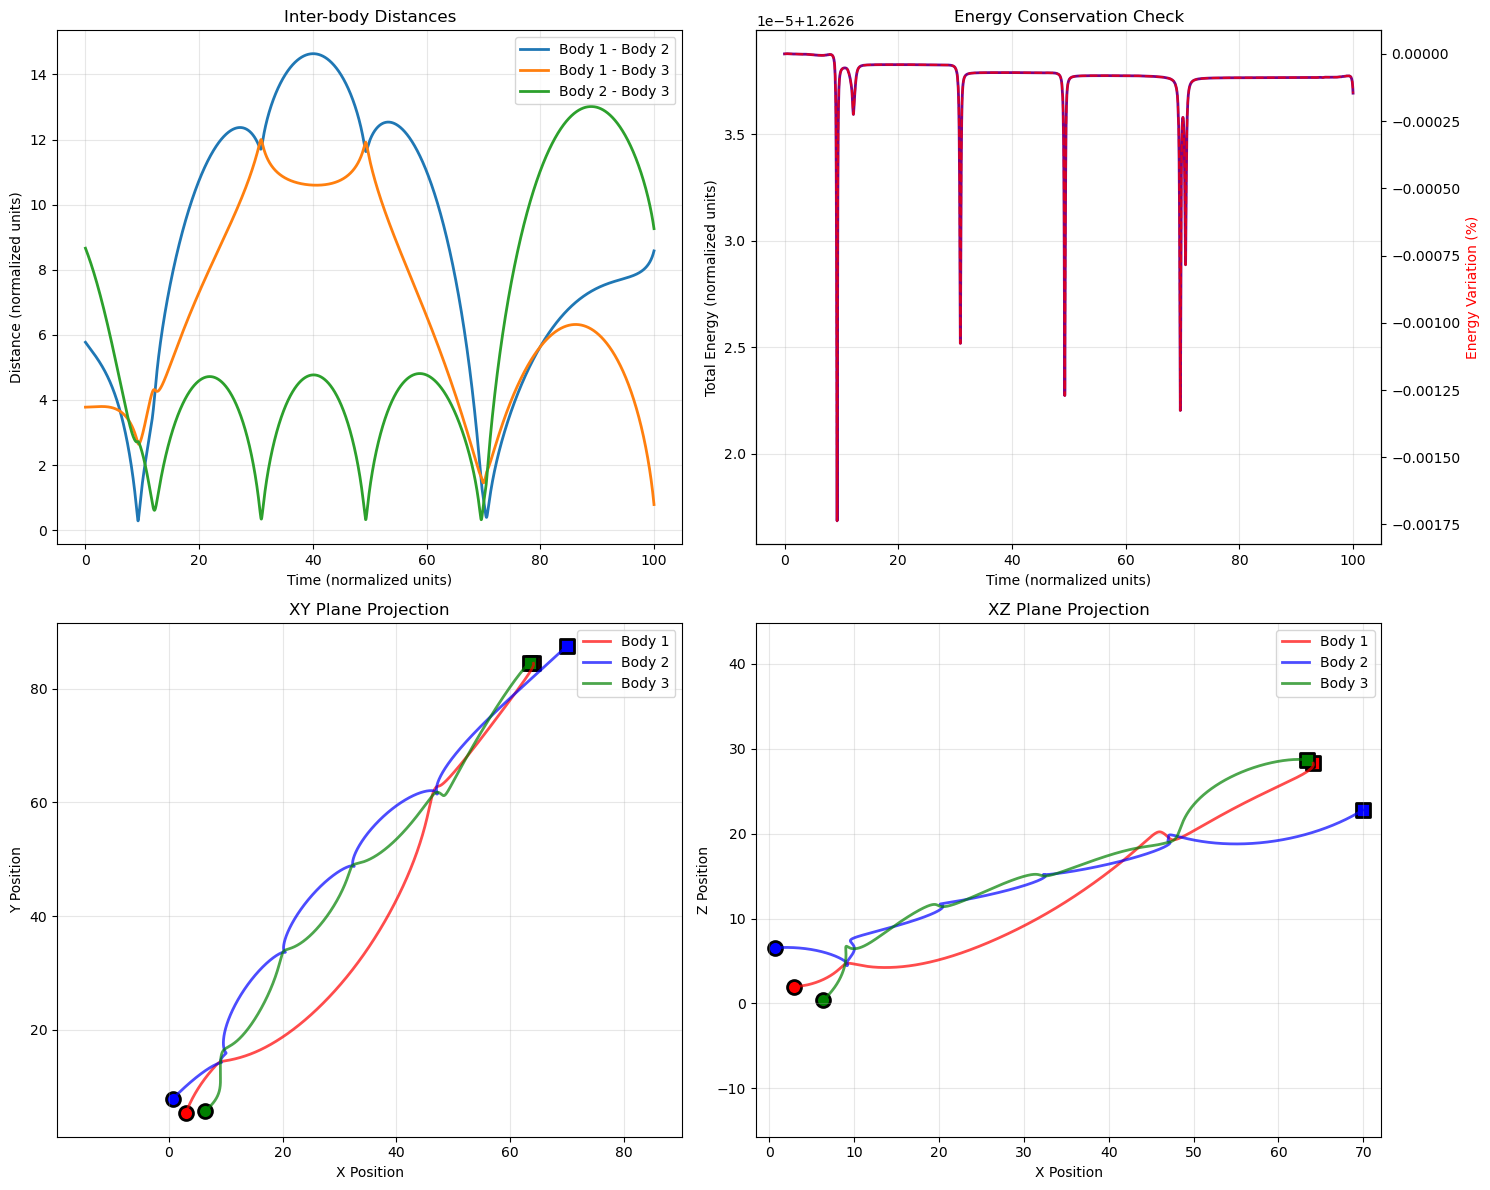

✓ Analysis plots completed!
Maximum energy variation: 0.00%


In [29]:
# Additional analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Inter-body distances vs time
ax1 = axes[0, 0]
time_in_units = time_array  # Keep original time units

for i in range(num_bodies):
    for j in range(i+1, num_bodies):
        # Calculate distance between bodies i and j
        x_i, y_i, z_i = trajectories[i]
        x_j, y_j, z_j = trajectories[j]
        
        inter_body_distances = np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2 + (z_i - z_j)**2)
        
        ax1.plot(time_in_units, inter_body_distances, 
                label=f'Body {i+1} - Body {j+1}', linewidth=2)

ax1.set_xlabel('Time (normalized units)')
ax1.set_ylabel('Distance (normalized units)')
ax1.set_title('Inter-body Distances')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Total energy of the system (conservation check)
ax2 = axes[0, 1]
total_system_energy = []

for time_idx in range(len(time_array)):
    # Kinetic energy
    kinetic_energy = 0
    for body_i in range(num_bodies):
        vx = solution[time_idx, 6*body_i + 3]
        vy = solution[time_idx, 6*body_i + 4] 
        vz = solution[time_idx, 6*body_i + 5]
        velocity_squared = vx**2 + vy**2 + vz**2
        kinetic_energy += 0.5 * body_masses[body_i] * velocity_squared
    
    # Potential energy
    potential_energy = 0
    for body_i in range(num_bodies):
        for body_j in range(body_i+1, num_bodies):
            x_i, y_i, z_i = solution[time_idx, 6*body_i:6*body_i+3]
            x_j, y_j, z_j = solution[time_idx, 6*body_j:6*body_j+3]
            distance = np.sqrt((x_i-x_j)**2 + (y_i-y_j)**2 + (z_i-z_j)**2)
            potential_energy -= G_gravitational * body_masses[body_i] * body_masses[body_j] / distance
    
    total_system_energy.append(kinetic_energy + potential_energy)

ax2.plot(time_in_units, total_system_energy, 'purple', linewidth=2)
ax2.set_xlabel('Time (normalized units)')
ax2.set_ylabel('Total Energy (normalized units)')
ax2.set_title('Energy Conservation Check')
ax2.grid(True, alpha=0.3)

# Show relative energy variation
energy_variation_percent = (np.array(total_system_energy) - total_system_energy[0]) / abs(total_system_energy[0]) * 100
ax2_twin = ax2.twinx()
ax2_twin.plot(time_in_units, energy_variation_percent, 'red', alpha=0.7, 
             linestyle='--', label='Variation %')
ax2_twin.set_ylabel('Energy Variation (%)', color='red')

# 3. XY plane projection
ax3 = axes[1, 0]
for i, (trajectory, color, label) in enumerate(zip(trajectories, body_colors, body_labels)):
    x_coords, y_coords, z_coords = trajectory
    ax3.plot(x_coords, y_coords, color=color, alpha=0.7, linewidth=2, label=label)
    ax3.scatter(x_coords[0], y_coords[0], color=color, s=100, marker='o', 
               edgecolors='black', linewidth=2)
    ax3.scatter(x_coords[-1], y_coords[-1], color=color, s=100, marker='s', 
               edgecolors='black', linewidth=2)

ax3.set_xlabel('X Position')
ax3.set_ylabel('Y Position')
ax3.set_title('XY Plane Projection')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.axis('equal')

# 4. XZ plane projection  
ax4 = axes[1, 1]
for i, (trajectory, color, label) in enumerate(zip(trajectories, body_colors, body_labels)):
    x_coords, y_coords, z_coords = trajectory
    ax4.plot(x_coords, z_coords, color=color, alpha=0.7, linewidth=2, label=label)
    ax4.scatter(x_coords[0], z_coords[0], color=color, s=100, marker='o', 
               edgecolors='black', linewidth=2)
    ax4.scatter(x_coords[-1], z_coords[-1], color=color, s=100, marker='s', 
               edgecolors='black', linewidth=2)

ax4.set_xlabel('X Position')
ax4.set_ylabel('Z Position')
ax4.set_title('XZ Plane Projection')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axis('equal')

plt.tight_layout()
plt.show()

print("✓ Analysis plots completed!")
print(f"Maximum energy variation: {np.max(np.abs(energy_variation_percent)):.2f}%")